Regional Minimum Value: -19.080966266063424
Corresponding Coordinates (x, y): (8.039622967664641, 9.552219161218108)
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2488 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1644         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0044200197 |
|    clip_fraction        | 0.0214       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.000338     |
|    learning_rate        | 0.0003       |
|    loss           

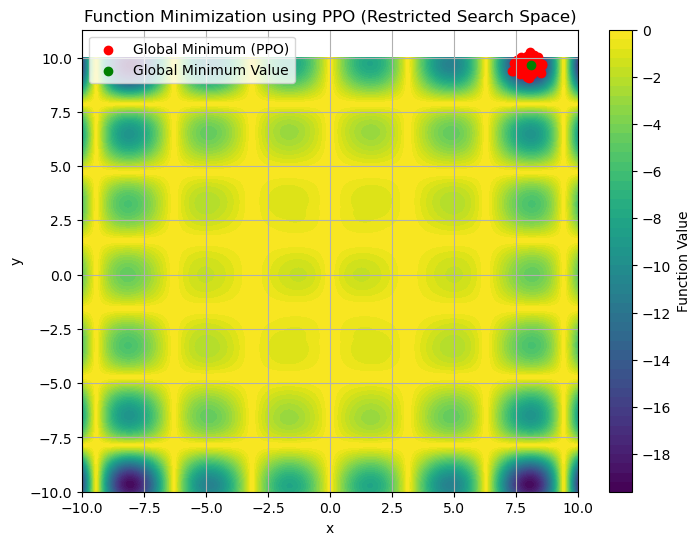

In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

# Holder Table function
def holder_table(x, y):
    a = np.abs(1 - np.sqrt(x**2 + y**2) / np.pi)
    return -np.abs(np.sin(x) * np.cos(y) * np.exp(a))

# Epsilon-greedy exploration
epsilon = 0.1  # Exploration probability
num_iterations = 1000  # Number of iterations

regional_min_value = float('inf')
regional_min_coordinates = None
function_values = []

for _ in range(num_iterations):
    if np.random.rand() < epsilon:
        # Explore: Randomly sample a point in the function space
        x = np.random.uniform(low=-10, high=10)
        y = np.random.uniform(low=-10, high=10)
    else:
        # Exploit: Choose the current best-known minimum
        x, y = regional_min_coordinates if regional_min_coordinates is not None else (np.random.uniform(low=-10, high=10),
                                                           np.random.uniform(low=-10, high=10))

    # Calculate function value
    value = holder_table(x, y)
    function_values.append(value)  # Store function values for visualization

    # Update global minimum if a lower value is found
    if value < regional_min_value:
        regional_min_value = value
        regional_min_coordinates = (x, y)

print("Regional Minimum Value:", regional_min_value)
print("Corresponding Coordinates (x, y):", regional_min_coordinates)

# Define the custom environment for Holder Table function
class CustomEnv(gym.Env):
    def __init__(self, global_min_region):
        super(CustomEnv, self).__init__()
        self.min_region = global_min_region
        self.observation_space = gym.spaces.Box(low=np.array(self.min_region) - 1, high=np.array(self.min_region) + 1, dtype=np.float32)  # Restricting the search space around (-8.226, -9.397) within 1 standard deviation
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.state = np.zeros(2)

    def reset(self):
        # Initialize the state within 1 standard deviation radius around (-8.226, -9.397)
        mean = np.array(self.min_region)
        std_dev = np.array([1, 1])  # 1 standard deviation radius
        self.state = np.random.normal(loc=mean, scale=std_dev)
        # Clip the state to stay inside the valid range
        self.state = np.clip(self.state, self.observation_space.low, self.observation_space.high)
        return self.state

    def step(self, action):
        # Clip actions to stay inside the valid range
        action = np.clip(action, self.action_space.low, self.action_space.high)
        self.state += action
        # Clip the state to stay inside the valid range
        self.state = np.clip(self.state, self.observation_space.low, self.observation_space.high)
        x, y = self.state
        reward = np.abs(np.sin(x) * np.cos(y) * np.exp(np.abs(1 - np.sqrt(x**2 + y**2)/np.pi)))
        done = False
        return self.state, reward, done, {}

# Create the custom environment
env = CustomEnv(regional_min_coordinates)

# Create the PPO agent
model = PPO("MlpPolicy", env, verbose=1)

# Train the agent
model.learn(total_timesteps=100000)
model.save("explore-exploit_PPO_model")

# Evaluate the trained agent
obs = env.reset()
min_values = []

model.load("explore-exploit_PPO_model")
for _ in range(100):
    action, _ = model.predict(obs)
    obs, _, done, _ = env.step(action)
    min_values.append(obs.copy())
    if done:
        obs = env.reset()

# Calculate and print the global minimum value
global_min = min(min_values, key=lambda x: holder_table(x[0], x[1]))
print(f"Global Minimum Value: {global_min}")

# Plot the function and the global minimum
x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(x, y)
Z = -np.abs(np.sin(X) * np.cos(Y) * np.exp(np.abs(1 - np.sqrt(X**2 + Y**2)/np.pi)))

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')
plt.scatter([point[0] for point in min_values], [point[1] for point in min_values], color='red', label='Global Minimum (PPO)')
plt.scatter(global_min[0], global_min[1], color='green', label='Global Minimum Value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Minimization using PPO (Restricted Search Space)')
plt.legend()
plt.grid(True)
plt.show()
env.close()